<a href="https://colab.research.google.com/github/Archalharin/229352-stat-for-data-science/blob/main/660510632_Lab10_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

# Lab 10: Image Segmentation with U-Net

In this lab, we move beyond classification (predicting one label per image) to **Semantic Segmentation** (predicting a label for every pixel).

We will use the **U-Net architecture**, a powerful encoder-decoder network originally designed for biomedical image segmentation, to segment pets from backgrounds using the **Oxford-IIIT Pet Dataset**.

### Learning Objectives:
1.  Understand the difference between Classification and Segmentation.
2.  Build the building blocks of U-Net (Double Conv, Down, Up).
3.  Implement a full U-Net architecture.
4.  Evaluate segmentation using Intersection over Union (IoU).

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import functional as TF
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## Part 1: Data Loading & Preprocessing

We will use the **Oxford-IIIT Pet Dataset**.
* **Input:** RGB Image of a pet (cat or dog).
* **Target:** A segmentation mask where each pixel denotes the class:
    * Class 0: Pet
    * Class 1: Background
    * Class 2: Border

**Note:** To ensure the lab runs in <20 mins, we resize images to `128x128`.

In [3]:
IMAGE_SIZE = 128
BATCH_SIZE = 32

class OxfordPetDataset(datasets.OxfordIIITPet):
    def __init__(self, root, split, target_types="segmentation", download=False):
        super().__init__(root=root, split=split, target_types=target_types, download=download)

    def __getitem__(self, idx):
        image, mask = super().__getitem__(idx)

        image = TF.resize(image, (IMAGE_SIZE, IMAGE_SIZE), interpolation=transforms.InterpolationMode.BILINEAR)
        mask = TF.resize(mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=transforms.InterpolationMode.NEAREST)

        image = TF.to_tensor(image) # Scales [0, 1]
        mask = torch.as_tensor(np.array(mask), dtype=torch.long) # Keep integer class labels

        mask = mask - 1

        return image, mask

print("Downloading Data... (this may take 1-2 minutes)")
train_data = OxfordPetDataset(root="data", split="trainval", download=True)
test_data = OxfordPetDataset(root="data", split="test", download=True)

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=128, shuffle=False)

print(f"\nTraining samples: {len(train_data)}")
print(f"Testing samples: {len(test_data)}")

100%|██████████| 792M/792M [00:28<00:00, 27.8MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 13.4MB/s]



Training samples: 3680
Testing samples: 3669


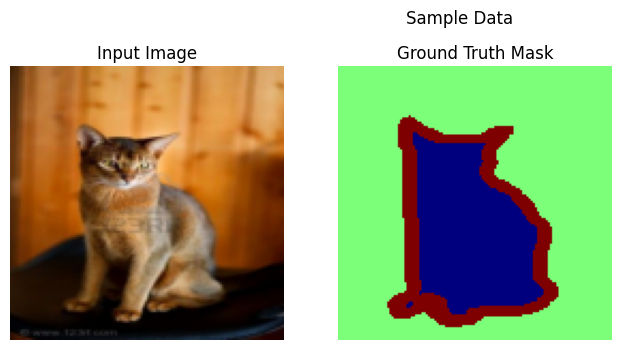

In [4]:
def visualize_sample(image, mask, pred=None, title=None):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(image.permute(1, 2, 0).cpu()) # C,H,W -> H,W,C
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask.cpu(), cmap='jet', vmin=0, vmax=2)
    plt.title("Ground Truth Mask")
    plt.axis("off")

    if pred is not None:
        plt.subplot(1, 3, 3)
        plt.imshow(pred.cpu(), cmap='jet', vmin=0, vmax=2)
        plt.title("Predicted Mask")
        plt.axis("off")

    if title:
        plt.suptitle(title)
    plt.show()

img, mask = train_data[random.randint(0, len(train_data)-1)]
visualize_sample(img, mask, title="Sample Data")

## Part 2: U-Net Building Blocks ([U-Net paper](https://arxiv.org/pdf/1505.04597))

<p align="middle">
  <img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" width="800" align="middle"/>
</p>  

U-Net is composed of three main parts:
1.  **Encoder:** convolution => [BN] => ReLU + MaxPool.
2.  **Decoder:** convolution => [BN] => ReLU + Transpose Convolutions, concatenated with skip connections from the encoder.

We define helper classes for these repeating blocks.

In [5]:
class DoubleConv(nn.Module):
    """
    (Conv -> BatchNorm -> ReLU) * 2
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """
    Downscaling with MaxPool -> DoubleConv
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        layers = [
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        ]

        self.maxpool_conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """
    Upscaling -> Concat -> DoubleConv
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # Handle cases where input size is not perfectly divisible by 2
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        # Concatenate along the channel axis
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

## Part 3: Demonstration - Small U-Net

Here I demonstrate a "Tiny" U-Net. It only has 2 levels of depth. It runs very fast but might miss fine details.

**Architecture:**
* Input -> Conv
* Down1 (32 -> 64)
* Down2 (64 -> 128)
* Up1 (128 -> 64)
* Up2 (64 -> 32)
* Output -> Classify

In [ ]:
class SmallUNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(SmallUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        # Encoder (n_channels => 32 => 64 => 128)
        self.conv_in = DoubleConv(3, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)


        # Decoder (128 => 64 => 32 => 1)
        self.up1 = Up(128, 64)
        self.up2 = Up(64, 32)
        self.conv_out = nn.Conv2d(32, 3, kernel_size=1) # Output



    def forward(self, x):
        # Encoder
        x1 = self.conv_in(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)



        # Decoder (with skip connections)
        x = self.up1(x3, x2)
        x = self.up2(x, x1)
        logits = self.conv_out(x)

        return logits

# Initialize Model
model_small = SmallUNet(n_channels=3, n_classes=3).to(device) # 3 classes: pet, bg, border

# Training Function
def train_segmentation(model, train_loader, test_loader, epochs=3):  #แนะนำ epochs = 10 เพื่อความแม่นยำ
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)

    print(f"Training {model.__class__.__name__}...")

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad(                       )
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for images, masks in test_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                test_loss += loss.item()

        print(f"Epoch {epoch+1}: Train Loss: {train_loss/len(train_loader):.4f} | Test Loss: {test_loss/len(test_loader):.4f}")

# Train the small model
train_segmentation(model_small, train_dataloader, test_dataloader, epochs=3)

Visualize results from UNet

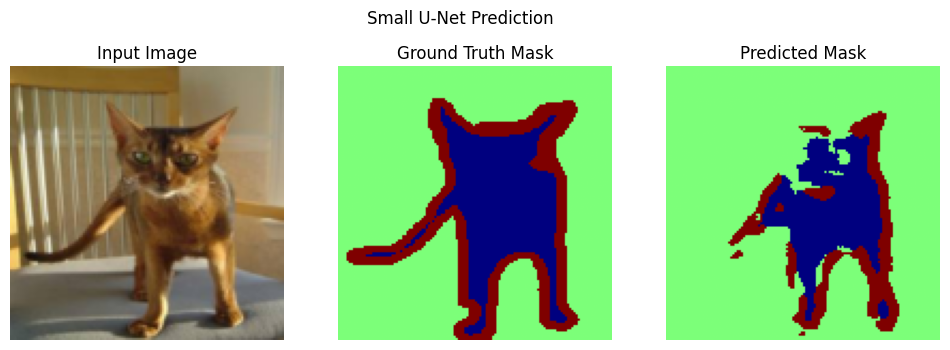

In [ ]:
model_small.eval()
img, mask = test_data[2]
with torch.no_grad():
    pred = model_small(img.unsqueeze(0).to(device))
    pred_mask = torch.argmax(pred, dim=1).squeeze(0)

visualize_sample(img, mask, pred_mask, title="Small U-Net Prediction")

### Evaluation: Intersection over Union (IoU)

Accuracy is misleading in segmentation because background pixels dominate the image. The standard metric is **IoU (Intersection over Union)**, also known as the Jaccard Index.

$$ IoU = \frac{\text{Intersection}}{\text{Union}} = \frac{|A \cap B|}{|A \cup B|} = \frac{TP}{TP + FP + FN} $$

Where:
* $A$ is the Ground Truth mask.
* $B$ is the Predicted mask.
* $TP$ = True Positive (Pixel correctly predicted as class X)
* $FP$ = False Positive (Pixel incorrectly predicted as class X)
* $FN$ = False Negative (Pixel of class X missed by prediction)

In [ ]:
def calculate_iou(pred_mask, true_mask, num_classes=3):
    iou_list = []
    pred_mask = pred_mask.view(-1)
    true_mask = true_mask.view(-1)

    for cls in range(num_classes):
        pred_inds = pred_mask == cls
        target_inds = true_mask == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()

        if union == 0:
            iou_list.append(float('nan')) # Ignore if class not present
        else:
            iou_list.append(intersection / union)
    return np.nanmean(iou_list)

# Calculate IoU for your model (uncomment below after implementing UNet)
model_small.eval()
total_iou = 0
count = 0
with torch.no_grad():
    for images, masks in test_dataloader:
        images = images.to(device)
        outputs = model_small(images)
        preds = torch.argmax(outputs, dim=1)
        total_iou += calculate_iou(preds.cpu(), masks)
        count += 1
print(f"Mean IoU on Test Set: {total_iou/count:.4f}")

Mean IoU on Test Set: 0.5436


## Part 4: Exercise - Implement a Deeper U-Net

The Small U-Net works, but a standard U-Net is deeper. Deeper networks capture more complex features.

**Your Task:**
1.  Implement a bigger `UNet` model below. I recommend for the encoder to go a lot higher than 128 channels.
2.  Train the model.
3.  Choose one test image whose model's segmentation is reasonably accurate. Visualize the model's segmentation of the chosen image.
4. Calculate the mean IoU of the model's segmentations on the test set.

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        # --- Write your code here ---
        # 1. Define Encoder
        self.conv_in = DoubleConv(3, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)



        # 2. Define Decoder

        self.up1 = Up(512, 256)
        self.up2 = Up(256, 128)
        self.up3 = Up(128, 64)
        self.conv_out = nn.Conv2d(64, n_classes, kernel_size=1)


    def forward(self, x):
        # --- Write your code here ---
        # 1. Forward pass through Encoder
        x1 = self.conv_in(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)



        # 2. Forward pass through Decoder

        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        logits = self.conv_out(x)

        return logits

# Instantiate your model
student_model = UNet(n_channels=3, n_classes=3).to(device)

# Train your model
def train_segmentation(model, train_loader, test_loader, epochs=15):  #แนะนำ epochs = 10 เพื่อความแม่นยำ
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)

    print(f"Training {model.__class__.__name__}...")

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, masks in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad(                       )
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for images, masks in test_dataloader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                test_loss += loss.item()

        print(f"Epoch {epoch+1}: Train Loss: {train_loss/len(train_loader):.4f} | Test Loss: {test_loss/len(test_loader):.4f}")

train_segmentation(student_model, train_dataloader, test_dataloader, epochs=15)

In [ ]:
train_segmentation(student_model, train_dataloader, test_dataloader, epochs=15)

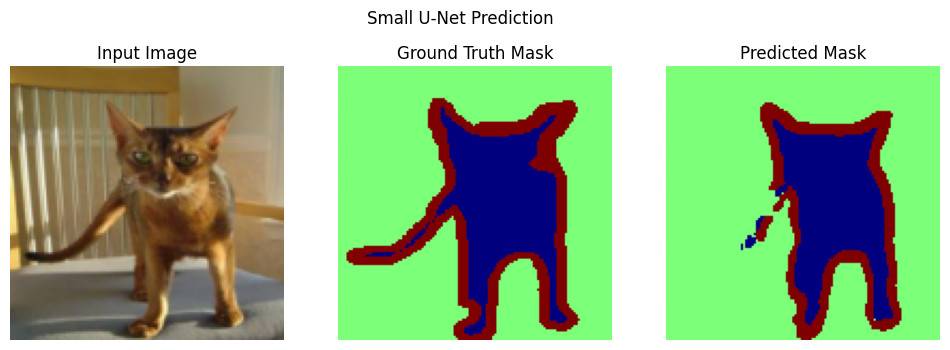

In [7]:
student_model.eval()
img, mask = test_data[2]
with torch.no_grad():
    pred = student_model(img.unsqueeze(0).to(device))
    pred_mask = torch.argmax(pred, dim=1).squeeze(0)

visualize_sample(img, mask, pred_mask, title="Small U-Net Prediction")

In [8]:
def calculate_iou(pred_mask, true_mask, num_classes=3):
    iou_list = []
    pred_mask = pred_mask.view(-1)
    true_mask = true_mask.view(-1)

    for cls in range(num_classes):
        pred_inds = pred_mask == cls
        target_inds = true_mask == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()

        if union == 0:
            iou_list.append(float('nan')) # Ignore if class not present
        else:
            iou_list.append(intersection / union)
    return np.nanmean(iou_list)

# Calculate IoU for your model (uncomment below after implementing UNet)
student_model.eval()
total_iou = 0
count = 0
with torch.no_grad():
    for images, masks in test_dataloader:
        images = images.to(device)
        outputs = student_model(images)
        preds = torch.argmax(outputs, dim=1)
        total_iou += calculate_iou(preds.cpu(), masks)
        count += 1
print(f"Mean IoU on Test Set: {total_iou/count:.4f}")

Mean IoU on Test Set: 0.6998
